In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# fixed parameters
L = 100
Lx, Ly = L, L
src = [0, 0]
k = 20 * 100

In [3]:
## hyperparameter
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(5e2)
learning_rate = 2e-5

In [5]:
def get_pde_point(Lx, Ly, src, n_coll=10000, device=device):
    # sample
    x, y = 2 * Lx * torch.rand(n_coll, 1) - Lx, 2 * Ly * torch.rand(n_coll, 1) - Ly
    # sample around src
    n = int(n_coll / 5)
    r, theta = 5 * torch.rand(n, 1).sqrt(), 2 * np.pi * torch.rand(n, 1)
    x[-n:], y[-n:] = r * torch.cos(theta) + src[0], r * torch.sin(theta) + src[1]

    return torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device),\
    torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)

def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(torch.abs(y) - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), -sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), -sy], dim=-1)
    return ex, ey

def loss_fn(model, Lx, Ly, src, k, L_pml=0.5, std=0.01, sigma0=5):
    x, y = get_pde_point(Lx, Ly, src)
    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)
    xy = torch.cat([x, y], dim=-1)
    
    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1].sum(), x, create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2].sum(), x, create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1].sum(), x, create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2].sum(), x, create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1].sum(), y, create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2].sum(), y, create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1].sum(), y, create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2].sum(), y, create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)

    f = 1 / (2 * np.pi * std ** 2) * torch.exp(-0.5 * (((x - src[0])/std)**2 + ((y - src[1])/std)**2))
    f = torch.cat([f, torch.zeros_like(f)], dim=-1)
    #phi = np.sqrt(2.) / 2 * torch.ones_like(f)
    #f = compl_mul(f, phi)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p) - f

    return (res ** 2).mean()

In [6]:
model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
model.apply(sine_init)
model.net[0].apply(first_layer_sine_init)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
l_lst = []

In [7]:
model = model.to(device)
for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    loss = loss_fn(model, Lx, Ly, src, k, L_pml=50, std=0.01, sigma0=5)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    if (epoch+1) % 50 == 0:
        l_lst.append(loss)

/tmp/ipykernel_21953/2977006644.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32, requires_grad=True).to(device),\
/tmp/ipykernel_21953/2977006644.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y, dtype=torch.float32, requires_grad=True).to(device)
 10%|█         | 51/500 [00:08<01:12,  6.19it/s]

Epoch 50, Loss: 10923833344.0


 20%|██        | 101/500 [00:16<01:04,  6.18it/s]

Epoch 100, Loss: 4879961600.0


 30%|███       | 151/500 [00:24<00:56,  6.16it/s]

Epoch 150, Loss: 2595892224.0


 40%|████      | 201/500 [00:32<00:48,  6.14it/s]

Epoch 200, Loss: 1583300352.0


 50%|█████     | 251/500 [00:41<00:40,  6.12it/s]

Epoch 250, Loss: 1123878656.0


 60%|██████    | 301/500 [00:49<00:32,  6.10it/s]

Epoch 300, Loss: 1000412352.0


 70%|███████   | 351/500 [00:57<00:24,  6.09it/s]

Epoch 350, Loss: 678609088.0


 80%|████████  | 401/500 [01:05<00:16,  6.07it/s]

Epoch 400, Loss: 534156768.0


 90%|█████████ | 451/500 [01:13<00:08,  6.06it/s]

Epoch 450, Loss: 405229536.0


100%|██████████| 500/500 [01:22<00:00,  6.10it/s]

Epoch 500, Loss: 329009856.0


In [7]:
import joblib
joblib.dump(model.state_dict(), 'model_no_boundary.joblib')

['model_no_boundary.joblib']

/home/zhufanjie/miniconda3/envs/work/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


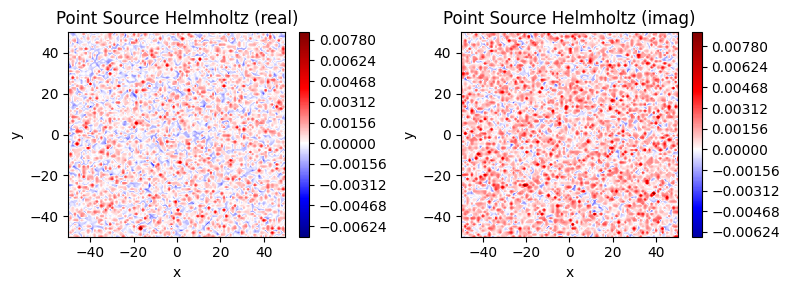

In [8]:
model_pred(model, Lx/2, Ly/2)

In [55]:
def plot_cut(model):
    x, y = torch.linspace(0, 0.5, 100), torch.zeros(100)
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    xy = torch.cat([x, y], dim=-1)
    p = model(xy)

    import scipy
    xx = np.linspace(0, 0.5, 100)
    hankel = scipy.special.hankel2(0, 20 * xx) * 0.25j
    plt.plot(x.detach().numpy(), (p[:, 0:1]).detach().numpy(), xx, hankel.real)

/tmp/ipykernel_28292/222225716.py:9: RuntimeWarning: invalid value encountered in multiply
  hankel = scipy.special.hankel2(0, 20 * xx) * 0.25j


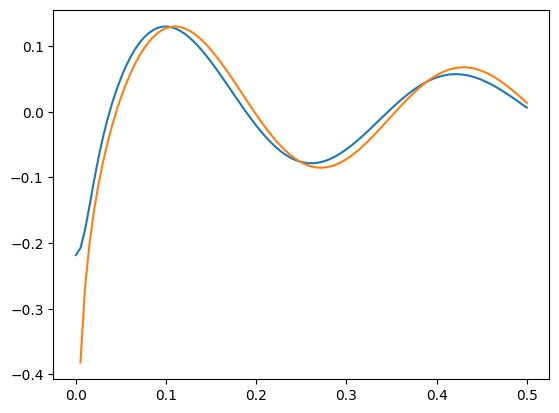

In [56]:
plot_cut(model.to('cpu'))